Duplicate of hsc_ffp but with upper stellar density limits

In [219]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [221]:
ti = 0.07
tf = 3
from LensCalcPy.parameters import *

In [122]:
def scientific_format(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"${} \times 10^{{{}}}$".format(mantissa, int(exponent))

def scientific_format_less(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"$10^{{{}}}$".format(int(exponent))

In [3]:
s = Survey(l, b, ds, obsTime, survey_area=survey_area, n_sources=n_sources)
s

Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, survey_area=0)

In [64]:
# Define Time Array
t_es = np.logspace(-2, 1, 20) #hours

In [5]:
#Power law index
p = 1
s.add_ffp(p)

In [6]:
def get_n_events(A, p=1, finite=True):
    #Now A is number of FFPs per star
    s.add_ffp(p)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime*A

def get_n_events_parallel(As, p=1, finite=True):
    with Pool() as p:
        f = functools.partial(get_n_events, p=p, finite=finite)
        results = list(p.imap(f, As))
    return results

## 2D exclusion plots

In [7]:
#Define range of parameters to consider
num_points = 20
p_min = 0.5
p_max = 1.5
p_values = np.linspace(p_min, p_max, num_points) 

In [8]:
M_sun = 1.99e30
M_earth = 5.97e24

def get_constraint_iso(m_iso, p=1, finite=True):
    if m_iso < 1e-15:
        raise ValueError('Mass must be greater than 1e-15')
    
    #Number of total events assuming 1 total per star
    #Note Z doesn't matter for this part of the calculation
    n_events = get_n_events(1, p=p, finite=finite)
    s.add_ffp(p)

    # Normalization check
    if abs(1 - nquad(s.ffp.mass_func,[[np.log10(s.ffp.m_min), np.log10(s.ffp.m_max)]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]) > 1e-2:
        raise ValueError('Normalization of mass function is off by more than 1e-2')

    #Porportion of ISOs above threshold
    proportion_above_threshold = nquad(s.ffp.mass_func,[[np.log10(m_iso), np.log10(s.ffp.m_max)]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]

    #New normalization for Z such that \Gamma *t_obs = 4.74
    N_thresh = 4.74/n_events

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_thresh * proportion_above_threshold    

def get_constraint_dex(m_iso, p=1, finite=True):
    if m_iso < 10**(-14.5):
        raise ValueError('Mass must be greater than 10**(-14.5)')
    
    #Number of total events assuming 1 total per star
    #Note Z doesn't matter for this part of the calculation
    n_events = get_n_events(1, p=p, finite=finite)
    s.add_ffp(p)

    #New normalization for Z such that \Gamma * t_obs = 4.74
    Z = 4.74/n_events

    # Normalization check
    if abs(1 - nquad(s.ffp.mass_func,[[np.log10(s.ffp.m_min), np.log10(s.ffp.m_max)]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]) > 1e-2:
        raise ValueError('Normalization of mass function is off by more than 1e-2')

    #Porportion of ISOs within threshold
    N_ffp_dex = Z * nquad(s.ffp.mass_func,[[np.log10(m_iso)-0.5,np.log10(m_iso)+0.5]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_ffp_dex

In [9]:
get_constraint_dex(3e-6, p=0.9, finite=True)

24311.33120565122

In [10]:
confidence_level_threshold = 0.05

#initialize variable Nexp
Nexp = 1
#number of observed events
n_events = 1

# Calculate the cumulative probability until it exceeds the threshold
while True:
    # cumulative_prob = poisson.pmf(0, Nexp) + poisson.pmf(1, Nexp) 
    cumulative_prob = 0
    for i in range(n_events+1):
        cumulative_prob += poisson.pmf(i, Nexp)

    # cumulative_prob = poisson.pmf(1, Nexp) 
    if cumulative_prob <= confidence_level_threshold:
        break
    Nexp += 0.01 

print(f"The 95% C.L. is reached when Nexp <= {Nexp}")

The 95% C.L. is reached when Nexp <= 4.749999999999942


### Constraints on local ISO Density

In [11]:
def get_n_events_pbh(m, finite=True):
    s.add_pbh(m)
    diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime

def get_constraint_fdm(m, finite=True):
    n_events = get_n_events_pbh(m, finite=finite)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1

def get_constraint_fdm_parallel(m_pbhs, finite=False):
    with Pool() as p:
        f = functools.partial(get_constraint_fdm, finite=finite)
        # results = list(p.imap(f, m_pbhs))
        results = list(tqdm(p.imap(f, m_pbhs), total=len(m_pbhs)))

    return results

In [12]:
#https://arxiv.org/pdf/1910.08608.pdf handwavy constraint in au^-3

local_dm_density = density_mw(dist_mw(0))
m_pbh = 1e-10
fpbh = get_constraint_fdm(m_pbh, finite=True)
kpc2au = 2.06e8

print("upper limit on number density of ISOs in au^-3 from HSC PBH constrint")
print(local_dm_density*kpc2au**(-3)*fpbh/m_pbh)

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


upper limit on number density of ISOs in au^-3 from HSC PBH constrint
3.423958963819863e-11


In [13]:
#Comparison with FFP distribution (new velocity dispersion)
# local_stellar_density = rho_FFPs_mw(0)
local_stellar_density = 0.1 * 1e9 # solar mass per cubic kpc

m_iso = 1e-10
alpha = 1.83

#number of ISOs per star with mass greater than m_iso
n_objects = get_constraint_iso(m_iso, p=p, finite=True)

print("upper limit on number density of ISOs in au^-3 with mass greater than {} for alpha = {}".format(m_iso, alpha))
print(local_stellar_density*kpc2au**(-3)*n_objects)

upper limit on number density of ISOs in au^-3 with mass greater than 1e-10 for alpha = 1.83
1.562520254237925e-09


Now do for different ISO masses

In [240]:
m_arr = np.array([M_EARTH])
m_arr 

array([3.e-06])

In [241]:
n_objects_dex_dict = {}

for m in m_arr:
    with Pool() as p:
        f = functools.partial(get_constraint_dex, m, finite=True)
        n_objects_dex_dict[m] = list(tqdm(p.imap(f, p_values), total=len(p_values)))

100%|██████████| 20/20 [05:04<00:00, 15.23s/it]


In [242]:
density = 2  # g/cm^3
msol_to_g = 1.99e33
diameters = {}

for m in m_arr:
    diameters[m] = (6*m*msol_to_g/(np.pi*density))**(1/3) * 1e-5 # diameter in km
diameters

{3e-06: 17864.131393727086}

In [247]:
#Pg 10 of https://arxiv.org/pdf/1910.08608.pdf
dohanyi_alpha = 2.5
dohanyi_p = dohanyi_alpha/3 
dohanyi_n = 7.2e-11

MOA_Z = 2.18
MOA_p = 0.96
KMT_Z = 0.4
KMT_p = 0.92

N_MOA = quad(lambda x: MOA_Z*(10**x/8)**(-MOA_p), np.log10(0.33), np.log10(6660))[0]
N_KMT = quad(lambda x: KMT_Z*(10**x/38)**(-KMT_p), np.log10(0.33), np.log10(6660))[0]

print(N_MOA)
print(N_KMT)

MOA_n = N_MOA * local_stellar_density * kpc2au ** (-3) 
KMT_n = N_KMT * local_stellar_density * kpc2au ** (-3) 

print("MOA number density: {}".format(MOA_n))
print("KMT number density: {}".format(KMT_n))

21.04411106964539
14.872261024601801
MOA number density: 2.407292840485934e-16
KMT number density: 1.7012782040484267e-16


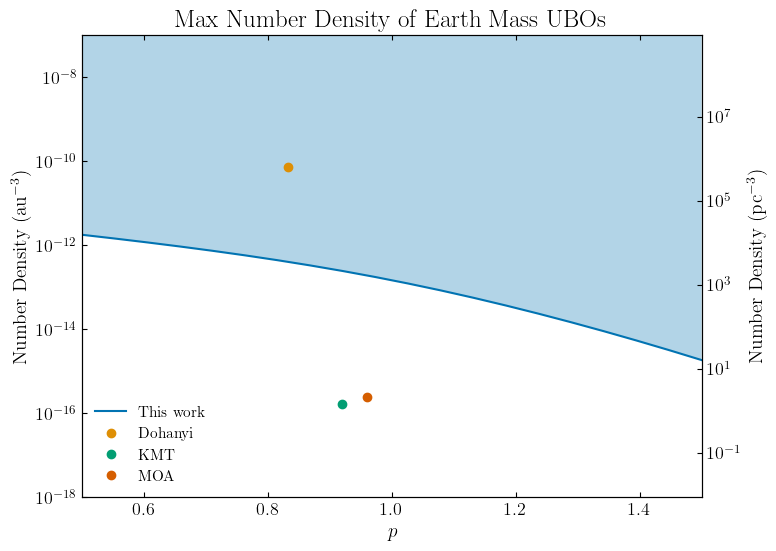

In [309]:
plt.figure()

# Loop over the dictionary items
for mass, n_objects_arr in n_objects_dex_dict.items():
    num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)
    # plt.plot(p_values, num_densities, label=r'$\rm{M_{ISO}}$ = M$_{\oplus}$')
    plt.plot(p_values, num_densities, label='This work')

    plt.fill_between(p_values, num_densities, 1, alpha=0.3)

plt.yscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$p$')
plt.title(r'Max Number Density of Earth Mass UBOs')

plt.xlim([min(p_values), max(p_values)])

#min and max number density in au^-3
ymin = 1e-18
ymax = 1e-7
plt.ylim([ymin, ymax])

plt.plot(dohanyi_p, dohanyi_n, 'o', label='Dohanyi')
plt.plot(KMT_p, KMT_n, 'o', label='KMT')
plt.plot(MOA_p, MOA_n, 'o', label='MOA')

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density (pc$^{-3}$)')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([ymin/au3_to_pc3, ymax/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

# plt.savefig('figures/number_density_iso_p.pdf')

plt.show()


### Now as a function of mass instead of p

In [263]:
m_values = np.logspace(-10, -4, 16) #in solar masses
# p_values_mass = np.linspace(0.6, 1.4, 3)
p_values_mass = np.array([0.66, 1, 1.33])

In [264]:
n_objects_dict_mass = {}
for p_val in p_values_mass:
    with Pool() as p:
        f = functools.partial(get_constraint_dex, p=p_val, finite=True)
        n_objects_dict_mass[p_val] = list(tqdm(p.imap(f, m_values), total=len(m_values)))


100%|██████████| 16/16 [03:49<00:00, 14.33s/it]


In [265]:
#https://arxiv.org/pdf/1910.08608.pdf handwavy constraint in au^-3

local_dm_density = density_mw(dist_mw(0))
m_pbh = 1e-10
fpbh = get_constraint_fdm(m_pbh, finite=True)
kpc2au = 2.06e8

print("upper limit on number density of UBOs in au^-3 from HSC PBH constrint")
print(local_dm_density*kpc2au**(-3)*fpbh/m_pbh)

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


upper limit on number density of UBOs in au^-3 from HSC PBH constrint
3.423958963819863e-11


In [255]:
# f_HM_bhatiani = 1e-4 * np.ones(len(ms_earth))/ nstar * rho_halo_Msol_pc3 / M_EARTH
# f_HM_bhatiani2 = 6e-4 * np.ones(len(ms_earth))/ nstar * rho_halo_Msol_pc3 / M_EARTH

In [262]:
n_bhatiani = 1e-4 * local_dm_density*kpc2au**(-3)
print(n_bhatiani/M_EARTH)
# n_bhatiani2 = 6e-4 * np.ones(len(ms_earth))/ nstar * rho_halo_Msol_pc3 / M_EARTH

2.4174129861229256e-17


In [271]:
def dN_dlogM(Z, M, M_norm, p):
    return Z * (M/M_norm)**-p

In [272]:
M_arr1 = np.logspace(-6, -3, 100)
M_arr2 = np.logspace(-24, -20, 100)
M_arr3 = np.logspace(-24, -3, 100)

dN_dlogM_arr_MOA = np.array([dN_dlogM(2.18, M, 3e-6*8, 0.96-0.27) for M in M_arr1])
dN_dlogM_arr_MOA2 = np.array([dN_dlogM(2.18, M, 3e-6*8, 0.96+0.47) for M in M_arr1])

# dN_dlogM_arr_KMT = np.array([dN_dlogM(0.4, M, 3e-6*38, 0.9) for M in M_arr1])
# dN_dlogM_arr_KMT2 = np.array([dN_dlogM(0.4, M, 3e-6*38, 1.2) for M in M_arr1])

dN_dlogM_arr_Do = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.66) for M in M_arr2])
dN_dlogM_arr_Do2 = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 1.33) for M in M_arr2])

dN_dlogM_arr_Do = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.92-0.06) for M in M_arr2])
dN_dlogM_arr_Do2 = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.92+0.06) for M in M_arr2])

dN_dlogM_arr_fit = np.array([dN_dlogM(0.4, M, 3e-6*38, 0.92) for M in M_arr3])

dN_dlogM_arr_ours = np.array([dN_dlogM(z_133, M, m_norm_133, 1.33) for M in M_arr3])
dN_dlogM_arr_ours2 = np.array([dN_dlogM(z_066, M, m_norm_066, 0.66) for M in M_arr3])

do_idx = np.where(abs(dN_dlogM_arr_Do-dN_dlogM_arr_Do2) == min(abs(dN_dlogM_arr_Do-dN_dlogM_arr_Do2)))[0][0]
kmt_idx = np.where(abs(dN_dlogM_arr_KMT-dN_dlogM_arr_KMT2) == min(abs(dN_dlogM_arr_KMT-dN_dlogM_arr_KMT2)))[0][0]
moa_idx = np.where(abs(dN_dlogM_arr_MOA-dN_dlogM_arr_MOA2) == min(abs(dN_dlogM_arr_MOA-dN_dlogM_arr_MOA2)))[0][0]


In [282]:
def get_num_density(Z, M, M_norm, p):
    '''
    Returns the number density of objects within 1 dex of M in au^-3
    '''
    M_arr = np.linspace(np.log10(M)-0.6, np.log10(M)+0.6, 100)
    dN_dlogM_arr = np.array([dN_dlogM(Z, 10**m, M_norm, p) for m in M_arr])
    interp = interp1d(M_arr, dN_dlogM_arr)
    return quad(interp, np.log10(M)-0.5, np.log10(M)+0.5)[0] * local_stellar_density * kpc2au ** (-3)

In [296]:
num_densities_MOA = np.array([get_num_density(2.18, M, 3e-6*8, 0.96) for M in m_values])
num_densities_KMT = np.array([get_num_density(0.4, M, 3e-6*38, 1.05) for M in m_values])
num_densities_Do = np.array([get_num_density(3.3e16, M, 3e-17 * 3e-6, 0.83) for M in m_values])

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_20045/1058410242.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(interp, np.log10(M)-0.5, np.log10(M)+0.5)[0] * local_stellar_density * kpc2au ** (-3)


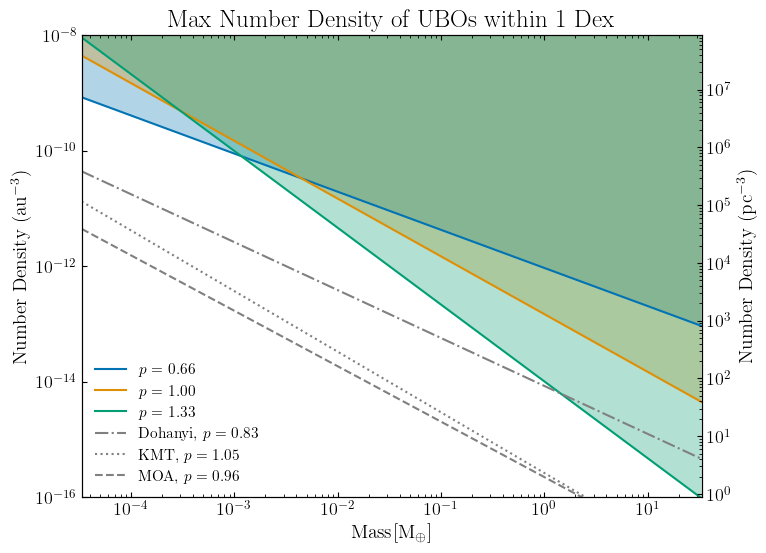

In [308]:
plt.figure()

# Loop over the dictionary items
for p, n_objects_arr in n_objects_dict_mass.items():
    num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

    plt.plot(m_values/M_EARTH, num_densities, label=f'$p = $ {p:.2f}')
    plt.fill_between(m_values/M_EARTH, num_densities, 1, alpha=0.3)

plt.plot(m_values/M_EARTH, num_densities_Do, label='Dohanyi, $p = 0.83$', color='gray', linestyle='-.')
plt.plot(m_values/M_EARTH, num_densities_KMT, label='KMT, $p = 1.05$', color='gray', linestyle=':')
plt.plot(m_values/M_EARTH, num_densities_MOA, label='MOA, $p = 0.96$', color='gray', linestyle='--')

plt.yscale('log')
plt.xscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$\rm{Mass} [ M_\oplus ]$')
plt.title(r'Max Number Density of UBOs within 1 Dex')

plt.xlim([min(m_values)/M_EARTH, max(m_values)/M_EARTH])

#min and max number density in au^-3
ymin = 1e-16
ymax = 1e-8
plt.ylim([ymin, ymax])

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density (pc$^{-3}$)')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([ymin/au3_to_pc3, ymax/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

# plt.savefig('figures/number_density_iso_mass.pdf')

plt.show()


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/ffp.py:222: RuntimeWarning: invalid value encountered in reciprocal
  return self.Z * (m/1)**-self.p


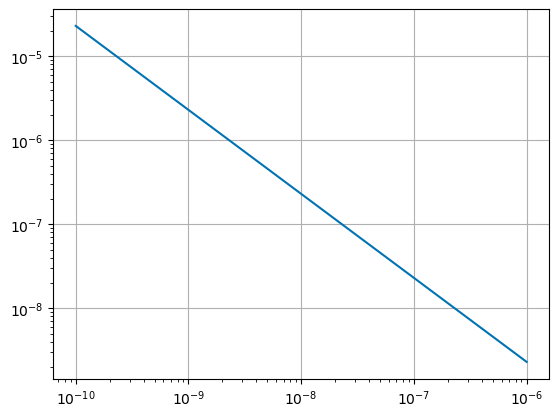

In [27]:
plt.loglog(m_arr,s.ffp.mass_func(np.log10(m_arr)))
plt.grid()
plt.show()

### Lightcurve of event

In [28]:
import pandas as pd

In [29]:
df = pd.read_csv('hsc_lightcurve.csv', header=None)
df.head()
lightcurve_interp = interp1d(df[0], df[1], kind='linear', bounds_error=False, fill_value=0)

In [30]:
#Calculate the full width half maximum of the light curve
def fwhm(time, flux):
    #find baseline flux
    # baseline = np.median(flux)
    baseline = np.mean(flux[0:10]) #use first 10 points as baseline
    half_max = (np.max(flux) + baseline ) / 2
    #find when the flux array is above half_max
    indexes = np.where(flux > half_max)
    
    return time[indexes[0][-1]], time[indexes[0][0]]

In [31]:
t_lightcurve = np.linspace(min(df[0]), max(df[0]), 1000)
counts_interp = lightcurve_interp(t_lightcurve)

In [32]:
fwhm_max, fwhm_min = fwhm(t_lightcurve, counts_interp)

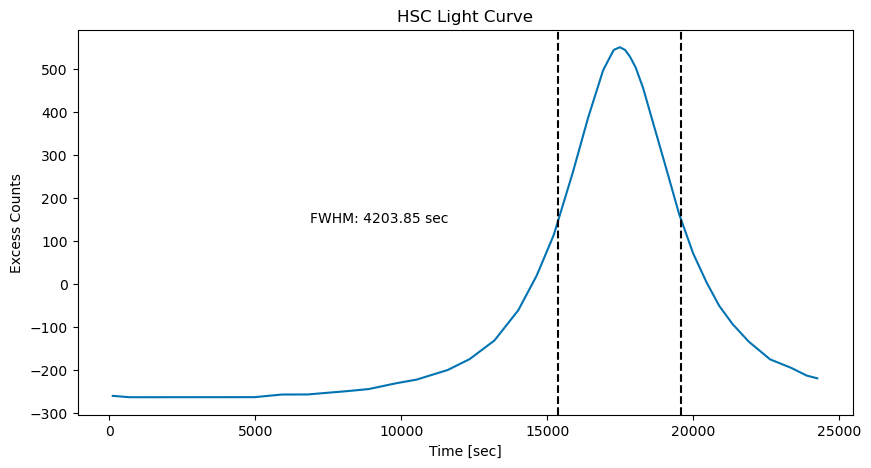

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(t_lightcurve, counts_interp)
plt.xlabel('Time [sec]')
plt.ylabel('Excess Counts')
plt.axvline(fwhm_min, color='k', linestyle='--')
plt.axvline(fwhm_max, color='k', linestyle='--')
plt.title('HSC Light Curve')
plt.text(0.3, 0.5, f'FWHM: {fwhm_max-fwhm_min:.2f} sec', transform=plt.gca().transAxes)
# plt.savefig('figures/hsc_lightcurve.pdf')
plt.show()


### Power law plots

In [35]:
def get_power_law(p, finite=True):
    n_events = get_n_events(1, p=p, finite=finite)
    s.add_ffp(p)

    #New normalization for Z such that \Gamma * t_obs = 4.74
    Z = 4.74/n_events * s.ffp.Z

    m_norm = s.ffp.M_norm

    return Z, m_norm
    

In [36]:
# z_133_10_bulge, m_norm_133_10_bulge = get_power_law(p=1.33)
# z_066_10_bulge, m_norm_066_10_bulge = get_power_law(p=0.66)

In [37]:
z_133, m_norm_133 = get_power_law(p=1.33)

In [38]:
z_066, m_norm_066 = get_power_law(p=0.66)

In [39]:
print(z_066,z_133)

16.822839872266147 2.7826595349425274e-05


In [40]:
z_066 * nquad(s.ffp.mass_func,[[np.log10(3e-6)-0.5,np.log10(3e-6)+0.5]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]

1.5623372039489313e-05

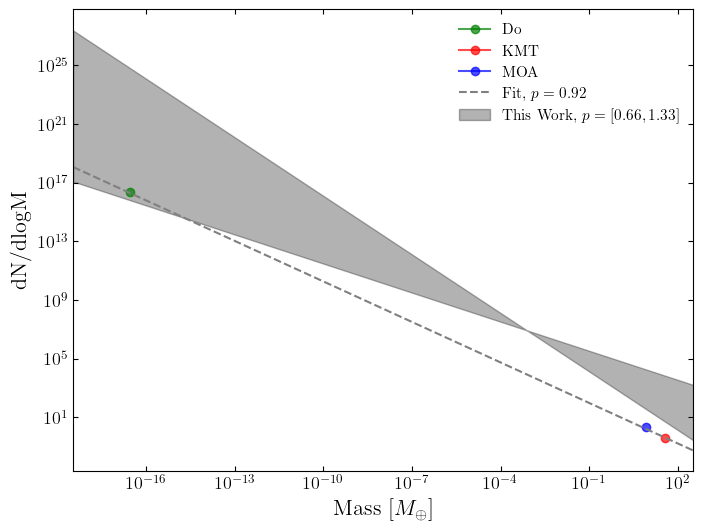

In [374]:
# plt.fill_between(M_arr1, dN_dlogM_arr_KMT, dN_dlogM_arr_KMT2, alpha=0.3, color='red', label='KMT, 0.9-1.2')
# plt.fill_between(M_arr1, dN_dlogM_arr_MOA, dN_dlogM_arr_MOA2, alpha=0.3, color='blue', label='MOA, 0.69 - 1.43')
# plt.fill_between(M_arr2, dN_dlogM_arr_Do, dN_dlogM_arr_Do2, alpha=0.3, color='green', label='Do, 0.66 - 1.33')

plt.plot(M_arr2[do_idx]/M_EARTH, dN_dlogM_arr_Do[do_idx]*0.7, alpha=0.7, color='green', marker='o', label='Do')
plt.plot(M_arr1[kmt_idx]/M_EARTH, dN_dlogM_arr_KMT[kmt_idx], alpha=0.7, color='red', marker='o', label='KMT')
plt.plot(M_arr1[moa_idx]/M_EARTH, dN_dlogM_arr_MOA[moa_idx], alpha=0.7, color='blue', marker='o', label='MOA')

plt.plot(M_arr3/M_EARTH, dN_dlogM_arr_fit, color='gray', label=r'Fit, $p = 0.92$', ls='--')

plt.fill_between(M_arr3/M_EARTH, dN_dlogM_arr_ours, dN_dlogM_arr_ours2, alpha=0.3, color='black', label=r'This Work, $p = [0.66, 1.33]$')

# plt.axvline(1e-9, color='black', ls='--')
# plt.axvline(1e-5, color='black', ls='--')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlim(min(M_arr2)/M_EARTH, max(M_arr1)/M_EARTH)

plt.xlabel(r"Mass [$M_{\oplus}$]", fontsize=16)
plt.ylabel(r'dN/dlogM', fontsize=16)

# plt.xlim(1e-7, 1e-1)

# plt.savefig('figures/mass_function_results.pdf')

plt.show()

Bulge comparison
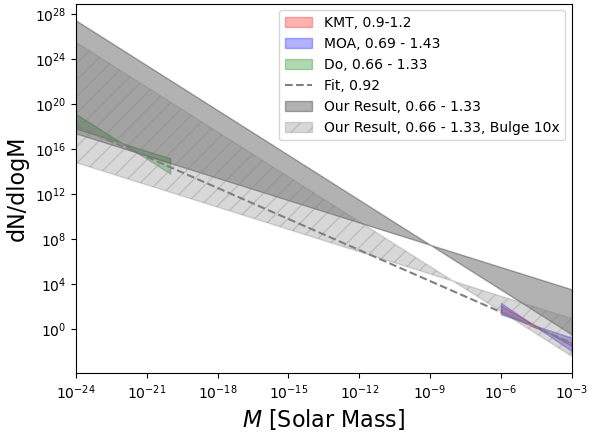

### Predicted Number of Events

In [42]:
# z_120_10_bulge, m_norm_120_10_bulge = get_power_law(p=1.20)
# z_090_10_bulge, m_norm_090_10_bulge = get_power_law(p=0.9)

In [43]:
# z_090_10_bulge_38earth = z_090_10_bulge*(3e-6*38)**(-1.33)
# z_120_10_bulge_38earth = z_120_10_bulge*(3e-6*38)**(-0.66)

# print(z_120_10_bulge)
# print(z_120_10_bulge_38earth)
# print(z_090_10_bulge)
# print(z_090_10_bulge_38earth)


In [44]:
def get_kmt_events(p):
    z, m_norm = get_power_law(p=p)
    # convert normalization to 38 earth mass to compare Z directly with KMT
    z_38earth = z*(3e-6*38)**(-p)
    #Our Z is calculated for 4.74 expected events. Convert
    num_events_kmt = 4.74*KMT_Z/z_38earth
    return num_events_kmt

In [45]:
p_kmt_arr = np.linspace(0.9, 1.2, 10)
num_events_kmt_arr = np.array([get_kmt_events(p) for p in p_kmt_arr])

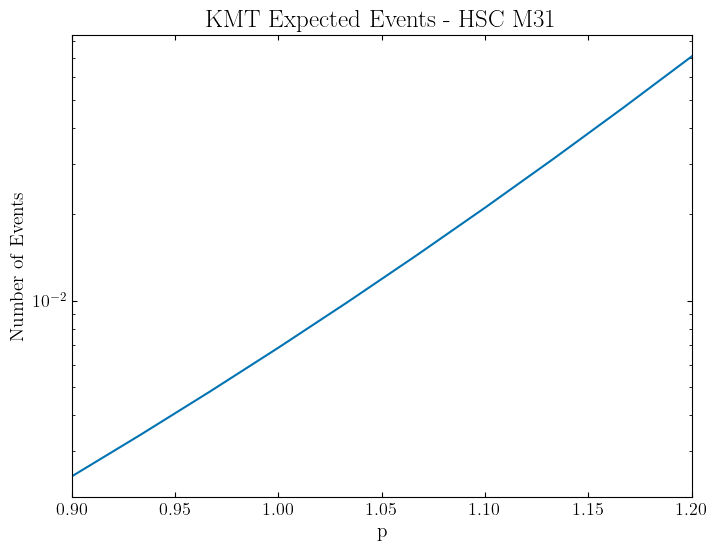

In [132]:
plt.plot(p_kmt_arr, num_events_kmt_arr)
plt.yscale('log')

plt.xlabel('p')
plt.ylabel('Number of Events')
plt.title('KMT Expected Events - HSC M31')

plt.xlim(min(p_kmt_arr), max(p_kmt_arr))
# plt.ylim(1e-1, 1e2)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# plt.savefig('figures/kmt_expected_events.pdf')

plt.show()

#KMT bulge comparison
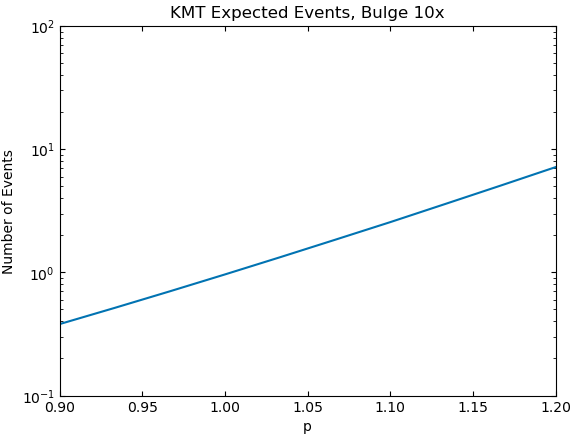

### Naive FFP Constraints from monochromatic PBH HSC

In [47]:
df = pd.read_csv('Roman_exclusion.csv', header=None)
df.head()
roman_exclusion_interp = interp1d(df[0], df[1], kind='linear', bounds_error=False, fill_value=0)

In [48]:
m_pbhs = np.logspace(-13, -4, 50) #solar masses

fdm_finite = get_constraint_fdm_parallel(m_pbhs, finite=True)

100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


In [49]:
nstar = 0.14 # per cubic parsec
rho_halo = 0.3 # GeV/cm^3
M_EARTH = 3e-6 # solar masses
M_SUN = 2e30 # kg
cm_to_pc = 3.24e-19
GeV_to_kg = 1.78e-27
GeV_to_solar_mass = GeV_to_kg / M_SUN
rho_halo_Msol_pc3 = rho_halo * GeV_to_solar_mass / cm_to_pc**3
rho_halo_Mearth_pc3 = rho_halo_Msol_pc3 / M_EARTH

f_HM = np.array(fdm_finite) / nstar * rho_halo_Msol_pc3 
# f_HM = np.array(fdms) / nstar * rho_halo_Msol_pc3 

ms_earth = m_pbhs/M_EARTH # convert to earth masses
f_HM_earth = f_HM/M_EARTH # convert to earth masses

In [203]:
f_HM_bhatiani = 1e-4 * np.ones(len(ms_earth))/ nstar * rho_halo_Msol_pc3 / M_EARTH
f_HM_bhatiani2 = 6e-4 * np.ones(len(ms_earth))/ nstar * rho_halo_Msol_pc3 / M_EARTH

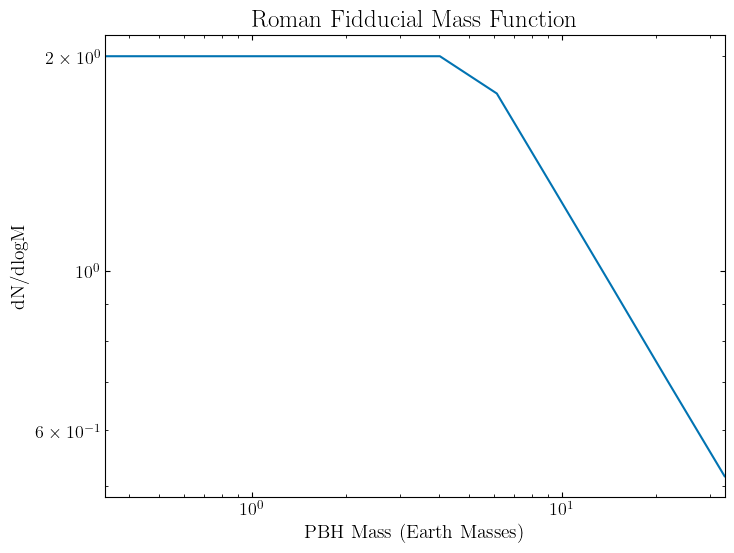

In [108]:
ms_1 = np.logspace(-16, np.log10(M_EARTH*5.2))
ms_2 = np.logspace(np.log10(M_EARTH*5.2), -1)

roman_dndlogm = np.array([2]*len(ms_1))
roman_dndlogm = np.append(roman_dndlogm, dN_dlogM(0.24, ms_2, 95*M_EARTH, 0.73))
# roman_dndlogm = np.append(roman_dndlogm, dN_dlogM(1/16.33180998152758, ms_2, 95*M_EARTH, 1.2))

roman_dndlogm_interp = interp1d(np.log10(np.append(ms_1, ms_2)), roman_dndlogm)

roman_dns = roman_dndlogm_interp(np.log10(m_pbhs))

plt.loglog(m_pbhs/M_EARTH, roman_dns)
plt.xlabel('FFP Mass (Earth Masses)')
plt.ylabel('dN/dlogM')
plt.title('Roman Fidducial Mass Function')

plt.xlim(1e-6/M_EARTH, 1e-4/M_EARTH)
plt.show()

In [51]:
def mass_in_ffps_dex(M, p):
    s.add_ffp(p)
    #number of ffps per star per Z
    # N_ffp_per_Z = nquad(s.ffp.mass_func,[[np.log10(M)-0.5,np.log10(M)+0.5]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]
    N_ffp_per_Z = 1

    mass_ffp_per_Z = N_ffp_per_Z * M
    return mass_ffp_per_Z


In [52]:
def mass_in_ffps_dex_roman(M):
    N_ffp_roman = nquad(roman_dndlogm_interp, [[np.log10(M)-0.5,np.log10(M)+0.5]])[0]
    return N_ffp_roman*M

print(mass_in_ffps_dex_roman(3e-6))
ms_roman = np.logspace(-15, -3, 100)
m_ffps_roman = np.array([mass_in_ffps_dex_roman(m) for m in ms_roman])

6e-06


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [53]:
m_ffps_066 = np.array([mass_in_ffps_dex(m, 0.66)*z_066 for m in ms_earth])
m_ffps_133 = np.array([mass_in_ffps_dex(m, 1.33)*z_133 for m in ms_earth])

In [54]:
roman_exclusion_ms = np.logspace(-4, 4, 100)
roman_exlusions = roman_exclusion_interp(roman_exclusion_ms)

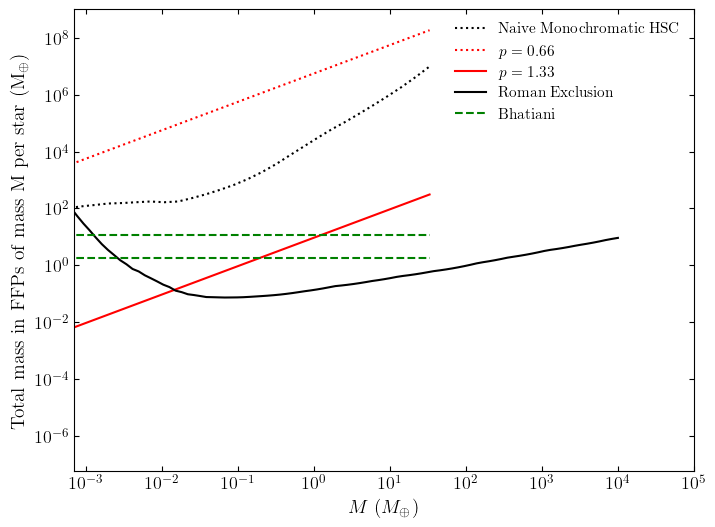

In [205]:
plt.loglog(ms_earth, f_HM_earth, 'k', ls=':', label='Naive Monochromatic HSC')
plt.loglog(ms_earth, m_ffps_066/M_EARTH, 'r', ls=':', label=r'$p=0.66$')
plt.loglog(ms_earth, m_ffps_133/M_EARTH, 'r', ls='-', label=r'$p=1.33$')
# plt.loglog(ms_roman/M_EARTH, m_ffps_roman/M_EARTH, 'Blue', ls='-.', label='Roman')
plt.loglog(roman_exclusion_ms, roman_exlusions, 'k', ls='-', label='Roman Exclusion')

plt.loglog(ms_earth, f_HM_bhatiani, 'green', ls='--', label='Bhatiani')
plt.loglog(ms_earth, f_HM_bhatiani2, 'green', ls='--')

plt.xlim(7e-4, 1e5)
# plt.ylim(7e-3, 1e6)

plt.xlabel(r'$M$ ($M_{\oplus}$)')
plt.ylabel('Total mass in UBOs of mass M per star (M$_{\oplus}$)')

plt.tick_params(axis='x', which='both', top=True, direction='in')
plt.tick_params(axis='y', which='both', right=True, direction='in')

# Set the tick spacing on the x-axis to be twice as dense
ax = plt.gca()
ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))

plt.legend()

plt.show()

In [56]:
def monochromatic_rate_ffp(m):

    ti = 0.07
    tf = 3

    #note p doesn't matter for monochromatic
    s.add_ffp(1)
    f = s.ffp
    ts = np.logspace(-2, 1, num=40)
    diff_rates_monochromatic_m31 = []
    diff_rates_monochromatic_mw = []
    for t in ts:
        diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=True, m=m))
        diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=True, m=m))
    
    diff_interp_m31 = interp1d(ts, diff_rates_monochromatic_m31)
    diff_interp_mw = interp1d(ts, diff_rates_monochromatic_mw)

    quad_m31 = quad(diff_interp_m31, ti, tf)[0]
    quad_mw = quad(diff_interp_mw, ti, tf)[0]

    return quad_m31 + quad_mw
    # return quad_mw


def expected_nevents_ffp_monochromatic(m):
    dnds = monochromatic_rate_ffp(m)
    n_exp = s.n_sources*efficiency*obsTime*dnds
    return n_exp

In [57]:
our_N_ffp_perstar = 4.74/np.array([expected_nevents_ffp_monochromatic(m) for m in m_pbhs])

In [58]:
# #Bulge LOS and 10x longer obs time
# our_N_ffp_perstar10 = 4.74/np.array([expected_nevents_ffp_monochromatic(m) for m in m_pbhs])

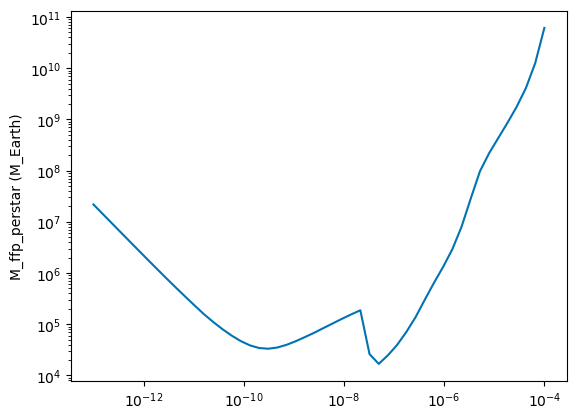

In [59]:
plt.loglog(m_pbhs, our_N_ffp_perstar*m_pbhs/M_EARTH)
# plt.loglog(m_pbhs, our_N_ffp_perstar10*m_pbhs/M_EARTH, ls='--', label='Bulge, 10x longer obs time')

# plt.ylabel('N_ffp_perstar')
plt.ylabel('M_UBO_perstar (M_Earth)')
plt.show()

In [60]:
our_Mffp_perstar_earth = our_N_ffp_perstar *m_pbhs/M_EARTH # Mass of FFPs per star in earth masses

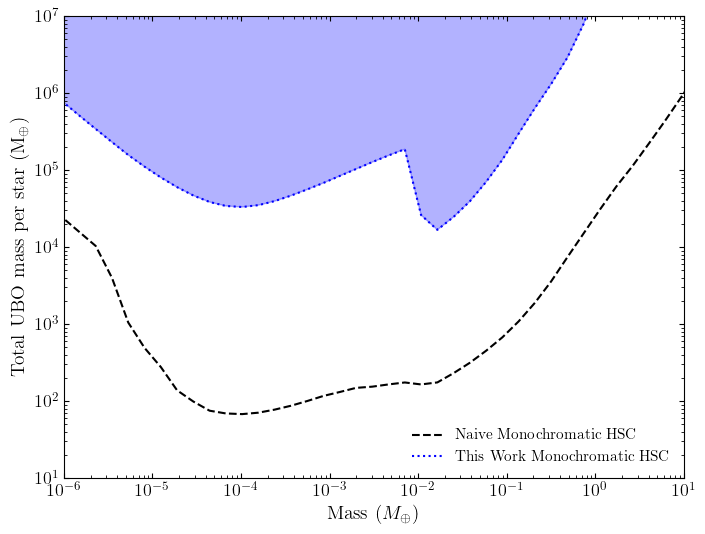

In [372]:
plt.loglog(ms_earth, f_HM_earth, 'k', ls='--', label='Naive Monochromatic HSC')
plt.loglog(ms_earth, our_Mffp_perstar_earth, 'blue', ls=':', label='This Work Monochromatic HSC')

plt.fill_between(ms_earth, our_Mffp_perstar_earth, 1e10, alpha=0.3, color='blue')

plt.xlim(1e-6, 1e1)
plt.ylim(1e1, 1e7)

plt.xlabel(r'Mass ($M_{\oplus}$)')
plt.ylabel('Total UBO mass per star (M$_{\oplus}$)')

plt.tick_params(axis='x', which='both', top=True, direction='in')
plt.tick_params(axis='y', which='both', right=True, direction='in')

# Set the tick spacing on the x-axis to be twice as dense
ax = plt.gca()
ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))

plt.legend(loc='lower right')

# plt.savefig('figures/monochromatic_mass.pdf')

plt.show()

### Velocity Dependence

In [215]:
p = 1.0
f = Ffp(p)
ts = np.logspace(-2, 1, num=40)
f

FFP with power law dN / dlogM ~ m^-1.0

In [216]:
diff_rates_finite_mw = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw.append(f.differential_rate_mw(t, finite=True))
diff_rates_finite_mw = np.array(diff_rates_finite_mw)

diff_rates_finite_m31 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31.append(f.differential_rate_m31(t, finite=True))
diff_rates_finite_m31 = np.array(diff_rates_finite_m31)

Computing differential rates for MW (finite=True): 100%|██████████| 40/40 [02:09<00:00,  3.23s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


In [222]:
diff_rates_finite_mw_60 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_60.append(f.differential_rate_mw(t, finite=True, v_disp=60))
diff_rates_finite_mw_60 = np.array(diff_rates_finite_mw_60)

diff_rates_finite_m31_120 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_120.append(f.differential_rate_m31(t, finite=True, v_disp=120))
diff_rates_finite_m31_120 = np.array(diff_rates_finite_m31_120)

Computing differential rates for MW (finite=True): 100%|██████████| 40/40 [02:25<00:00,  3.64s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


In [223]:
diff_rates_finite_mw_15 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_15.append(f.differential_rate_mw(t, finite=True, v_disp=15))
diff_rates_finite_mw_15 = np.array(diff_rates_finite_mw_15)

diff_rates_finite_m31_30 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_30.append(f.differential_rate_m31(t, finite=True, v_disp=30))
diff_rates_finite_m31_30 = np.array(diff_rates_finite_m31_30)

Computing differential rates for MW (finite=True): 100%|██████████| 40/40 [02:05<00:00,  3.13s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


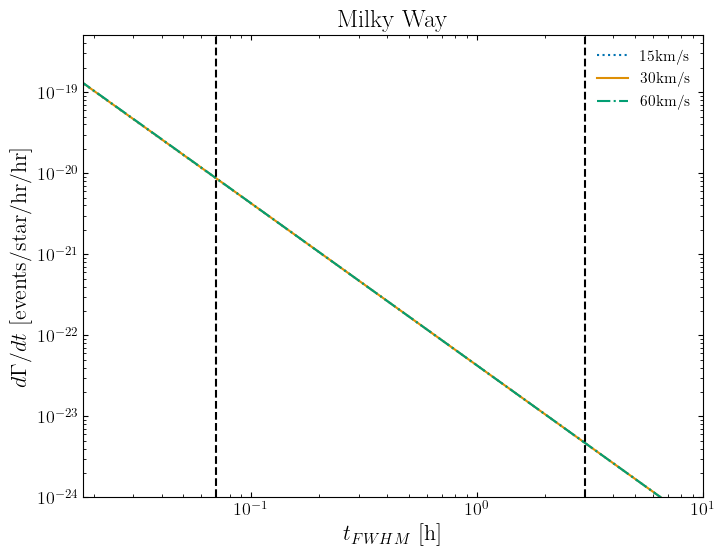

In [361]:
plt.loglog(ts, diff_rates_finite_mw_15, label="15km/s", linestyle=':')
plt.loglog(ts, diff_rates_finite_mw, label="30km/s", linestyle='-')
plt.loglog(ts, diff_rates_finite_mw_60, label="60km/s", linestyle='-.')

plt.axvline(ti, color='black', linestyle='--')
plt.axvline(tf, color='black', linestyle='--')

plt.xlabel(r"$t_{FWHM}$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.title('Milky Way')
plt.xlim(min(ts)*1.8, max(ts))
plt.ylim(1e-24,5e-19)
plt.legend()
plt.show()

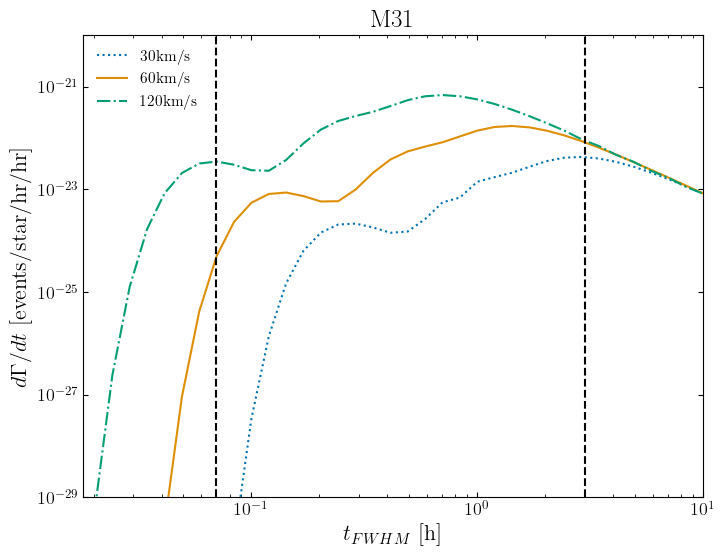

In [237]:
plt.loglog(ts, diff_rates_finite_m31_30, label="30km/s ", linestyle=':')
plt.loglog(ts, diff_rates_finite_m31, label="60km/s ", linestyle='-')
plt.loglog(ts, diff_rates_finite_m31_120, label="120km/s ", linestyle='-.')

plt.axvline(ti, color='black', linestyle='--')
plt.axvline(tf, color='black', linestyle='--')

plt.xlabel(r"$t_{FWHM}$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.title('M31')
plt.xlim(min(ts)*1.8, max(ts))
plt.ylim(1e-29,1e-20)
plt.legend()
plt.show()

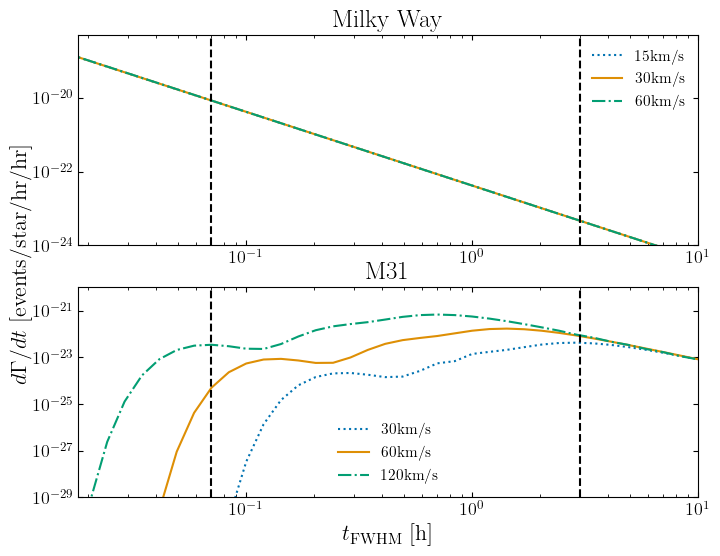

In [371]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2)

# First subplot
axs[0].loglog(ts, diff_rates_finite_mw_15, label="15km/s", linestyle=':')
axs[0].loglog(ts, diff_rates_finite_mw, label="30km/s", linestyle='-')
axs[0].loglog(ts, diff_rates_finite_mw_60, label="60km/s", linestyle='-.')

axs[0].axvline(ti, color='black', linestyle='--')
axs[0].axvline(tf, color='black', linestyle='--')

axs[0].set_title('Milky Way')
axs[0].set_xlim(min(ts)*1.8, max(ts))
axs[0].set_ylim(1e-24,5e-19)
axs[0].legend()

# Second subplot
axs[1].loglog(ts, diff_rates_finite_m31_30, label="30km/s ", linestyle=':')
axs[1].loglog(ts, diff_rates_finite_m31, label="60km/s ", linestyle='-')
axs[1].loglog(ts, diff_rates_finite_m31_120, label="120km/s ", linestyle='-.')

axs[1].axvline(ti, color='black', linestyle='--')
axs[1].axvline(tf, color='black', linestyle='--')

axs[1].set_xlabel(r"$t_{\rm{FWHM}}$ [h]", fontsize=16)
axs[1].set_title('M31')
axs[1].set_xlim(min(ts)*1.8, max(ts))
axs[1].set_ylim(1e-29,1e-20)
axs[1].legend()

fig.text(0.04, 0.5, r"$d\Gamma/dt$ [events/star/hr/hr]", va='center', rotation='vertical', fontsize=16)

# plt.savefig('figures/differential_rate_velocity.pdf')
# Show plot
# plt.tight_layout()
plt.show()


### Mass sensitivity

In [321]:
def monochromatic_rate_ffp(m):
    ti = 0.07
    tf = 3

    #value of p doesn't matter here since it's monchromatic
    f = Ffp(1)
    ts = np.logspace(-3, 1, num=40)
    diff_rates_monochromatic_m31 = []
    diff_rates_monochromatic_mw = []
    for t in ts:
        diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=True, m=m))
        diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=True, m=m))
    
    diff_interp_m31 = interp1d(ts, diff_rates_monochromatic_m31)
    diff_interp_mw = interp1d(ts, diff_rates_monochromatic_mw)

    quad_m31 = quad(diff_interp_m31, ti, tf)[0]
    quad_mw = quad(diff_interp_mw, ti, tf)[0]

    return quad_m31 + quad_mw


In [347]:
m_arr = np.logspace(-10, -4, 100) #solar masses
p = 1
with Pool() as pool:
    rates = list(tqdm(pool.imap(monochromatic_rate_ffp, m_arr), total=len(m_arr)))

100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


In [348]:
rate_interp = interp1d(m_arr, rates, kind='linear')

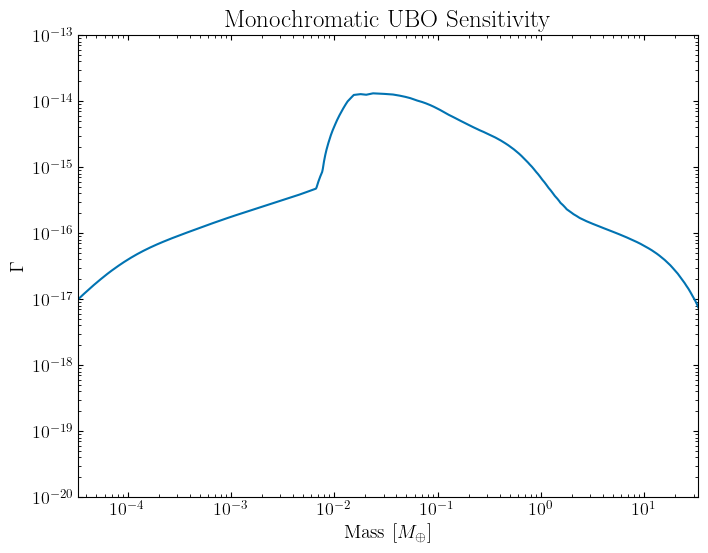

In [352]:
m_arr_2 = np.logspace(-10, -4, 1000) #solar masses
plt.plot(m_arr_2/M_EARTH, rate_interp(m_arr_2))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$\Gamma$")
plt.title("Monochromatic UBO Sensitivity")

plt.xlim(min(m_arr_2)/M_EARTH, max(m_arr_2)/M_EARTH)
plt.ylim(1e-20, 1e-13)

# plt.savefig('figures/monochromatic_sensitivity.pdf')

plt.show()
